In [5]:
import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dlib
import time

In [6]:
detector = dlib.get_frontal_face_detector() #Face detector
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [7]:
data = pd.read_csv('data/fer2013.csv')

In [8]:
'''
0 - Anger
1 - Disgust
2 - Fear
3 - Happiness
4 - Sadness
5 - Surprise
6 - Neutral
'''

N = 1000
D = data
data.groupby('Usage').count()

,emotion,pixels
Usage,,
PrivateTest,3589,3589
PublicTest,3589,3589
Training,28709,28709


In [9]:
training_image = []
training_label_full = []
test_image = []
test_label_full = []

start_time = time.time()
for index, row in D.iterrows():
    if row['Usage'] == 'Training':
        training_image.append(np.reshape(np.array(row['pixels'].split(), dtype=np.uint8), (48, 48)))
        training_label_full.append(row['emotion'])
    else:
        test_image.append(np.reshape(np.array(row['pixels'].split(), dtype=np.uint8), (48, 48)))
        test_label_full.append(row['emotion'])
        
print('time taken - %f sec'%(time.time() - start_time))

time taken - 43.120812 sec


In [10]:
def get_landmarks(_image):
    image = _image.copy()
    detections = detector(image, 1)
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        xlist = []
        ylist = []
        for i in range(1,68): #Store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
                
#         xmean = np.mean(xlist) #Get the mean of both axes to determine centre of gravity
#         ymean = np.mean(ylist)
        xmean = xlist[29]
        ymean = ylist[29]
        xcentral = [(x-xmean) for x in xlist] #get distance between each point and the central point in both axes
        ycentral = [(y-ymean) for y in ylist]
        
        # point 29 - nose tip
        # point 26 - middle point b/w two eyes
        cv.circle(image, (int(xlist[29]), int(ylist[29])), 1, (0,0,255))
        
        angle_nose = np.arctan2((ylist[26]-ymean), (xlist[26]-xmean)) * 180 / np.pi
        if angle_nose < 0:
            angle_nose += 90
        else:
            angle_nose -= 90
            
#         print(angle_nose)

        landmarks_vectorised = []
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
            landmarks_vectorised.append(x) #Add the coordinates relative to the centre of gravity
            landmarks_vectorised.append(y)

            #Get the euclidean distance between each point and the centre point (the vector length)
            meannp = np.asarray((ymean,xmean))
            coornp = np.asarray((z,w))
            dist = np.linalg.norm(coornp-meannp)
            landmarks_vectorised.append(dist)

            #Get the angle the vector describes relative to the image, corrected for the offset that the nosebrigde has when the face is not perfectly horizontal
            anglerelative = (np.arctan2((z - ymean), (w - xmean)) * 180 / np.pi) - angle_nose
            landmarks_vectorised.append(anglerelative)
        
    if len(detections) < 1: 
        landmarks_vectorised = "error"     
    
    return landmarks_vectorised

In [11]:
def make_sets():
    training_data = []
    test_data = []
    training_label = []
    test_label = []
    
    #Append data to training and prediction list, and generate labels 0-7
    index = 0
    
    start_time = time.time()
    
    for item in training_image:
        # image = cv.imread(item) #open image
        # gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY) #convert to grayscale
        # clahe_image = clahe.apply(gray)
#         print(index)
        landmarks_vectorised = get_landmarks(item)
        if landmarks_vectorised == "error":
            pass
        else:
            training_data.append(landmarks_vectorised) #append image array to training data list
            training_label.append(training_label_full[index])
            
        index += 1
        
    print('train - ', time.time() - start_time)
    
    index = 0
    for item in test_image:
        # image = cv.imread(item)
        # gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        # clahe_image = clahe.apply(gray)
#         print(index)
        landmarks_vectorised = get_landmarks(item)
        if landmarks_vectorised == "error":
            pass
        else:
            test_data.append(landmarks_vectorised)
            test_label.append(test_label_full[index])
            
        index += 1
        
    print('test - ', time.time() - start_time)

    return training_data, test_data, training_label, test_label

# --------------------------------------------------------

train_data, test_data, training_label, test_label = make_sets()

print(len(train_data), len(training_label))

# pd.DataFrame(train_data)
# pd.DataFrame(test_data)

('train - ', 104.61397886276245)
('test - ', 129.03816199302673)
(19863, 19863)


In [12]:
from sklearn import svm

start_time = time.time()

clf = svm.SVC(kernel='rbf', gamma=2)
clf.fit(train_data, training_label)

print('fit time - ', time.time() - start_time, ' sec')

('fit time - ', 362.7206859588623, ' sec')


In [13]:
start_time = time.time()
predicted_labels = clf.predict(test_data)
print('predict time - ', time.time() - start_time, ' sec')

('predict time - ', 27.23304796218872, ' sec')


In [14]:
print('Training accuracy (using kernel SVC) - ', np.mean(predicted_labels == test_label) * 100)

('Training accuracy (using kernel SVC) - ', 35.860531116967366)


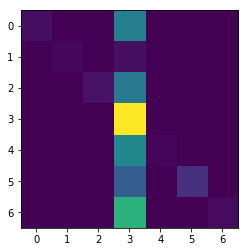

,0,1,2,3,4,5,6
0,51.0,0.0,2.0,591.0,1.0,0.0,0.0
1,1.0,27.0,0.0,57.0,0.0,0.0,0.0
2,1.0,0.0,69.0,569.0,1.0,1.0,1.0
3,0.0,0.0,0.0,1373.0,0.0,1.0,1.0
4,2.0,0.0,1.0,642.0,23.0,0.0,0.0
5,0.0,0.0,3.0,412.0,0.0,187.0,0.0
6,0.0,0.0,0.0,877.0,0.0,0.0,39.0


In [27]:
## confusion matrix
confusion_matrix = np.zeros((7, 7))
for actual, pred in zip(test_label, predicted_labels):
    confusion_matrix[actual, pred] += 1

plt.imshow(confusion_matrix)    
plt.show()

pd.DataFrame(confusion_matrix)

In [21]:
from sklearn.neural_network import MLPClassifier

nn_clf = MLPClassifier(solver='lbfgs', alpha=1e-6, hidden_layer_sizes=(100), random_state=1, max_iter=500)
nn_clf.fit(train_data, training_label)

MLPClassifier(activation='relu', alpha=1e-06, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=100, learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [22]:
start_time = time.time()
nn_predicted_labels = nn_clf.predict(test_data)
print('predict time - ', time.time() - start_time, ' sec')

('predict time - ', 0.14679813385009766, ' sec')


In [23]:
print('Training accuracy (using MLP) - ', np.mean(nn_predicted_labels == test_label) * 100)

('Training accuracy (using MLP) - ', 50.516926819379691)


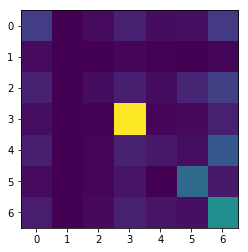

,0,1,2,3,4,5,6
0,213.0,2.0,36.0,104.0,40.0,50.0,200.0
1,36.0,1.0,2.0,15.0,7.0,4.0,20.0
2,110.0,2.0,41.0,100.0,41.0,124.0,224.0
3,42.0,1.0,8.0,1175.0,15.0,30.0,104.0
4,97.0,0.0,16.0,107.0,81.0,42.0,325.0
5,33.0,0.0,14.0,66.0,4.0,404.0,81.0
6,89.0,1.0,32.0,104.0,63.0,50.0,577.0


In [37]:
## confusion matrix
confusion_matrix = np.zeros((7, 7))
for actual, pred in zip(test_label, nn_predicted_labels):
    confusion_matrix[actual, pred] += 1

plt.imshow(confusion_matrix)    
plt.show()
plt.savefig('conf.png')

pd.DataFrame(confusion_matrix)

Normalized confusion matrix
[[  3.30232558e-01   3.10077519e-03   5.58139535e-02   1.61240310e-01
    6.20155039e-02   7.75193798e-02   3.10077519e-01]
 [  4.23529412e-01   1.17647059e-02   2.35294118e-02   1.76470588e-01
    8.23529412e-02   4.70588235e-02   2.35294118e-01]
 [  1.71339564e-01   3.11526480e-03   6.38629283e-02   1.55763240e-01
    6.38629283e-02   1.93146417e-01   3.48909657e-01]
 [  3.05454545e-02   7.27272727e-04   5.81818182e-03   8.54545455e-01
    1.09090909e-02   2.18181818e-02   7.56363636e-02]
 [  1.45209581e-01   0.00000000e+00   2.39520958e-02   1.60179641e-01
    1.21257485e-01   6.28742515e-02   4.86526946e-01]
 [  5.48172757e-02   0.00000000e+00   2.32558140e-02   1.09634551e-01
    6.64451827e-03   6.71096346e-01   1.34551495e-01]
 [  9.71615721e-02   1.09170306e-03   3.49344978e-02   1.13537118e-01
    6.87772926e-02   5.45851528e-02   6.29912664e-01]]


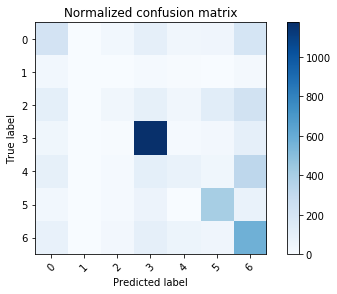

In [39]:
# import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt.figure()
plot_confusion_matrix(confusion_matrix, classes=np.arange(7), normalize=True,
                      title='Normalized confusion matrix')
plt.show()